# DATA SCIENCE TASK AT THE SPARKS FOUNDATION @GRIPMAY21
## TASK 6 : Stock Market Prediction using Numerical and Textual Analysis

Create a hybrid model for stock price or performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines. The stock to analyze and predict is SENSEX (S&P BSE SENSEX)

#### Data Sources:
 - Historical stock prices: finance.yahoo.com
 - Textual (news) data: https://bit.ly/36fFPI6


# By- Deepika Bisht

In [1]:
# importing libraries
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

!pip install tensorflow
!pip install keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

import nltk
nltk.download('vader_lexicon')
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# reading the datasets into pandas
df1 = pd.read_csv('GOOG.csv')
df2 = pd.read_csv('india-news-headlines.csv')

In [3]:
df1.head(3) 

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-05-19,1386.996948,1392.000000,1373.484985,1373.484985,1373.484985,1280600
1,2020-05-20,1389.579956,1410.420044,1387.250000,1406.719971,1406.719971,1655400
2,2020-05-21,1408.000000,1415.489990,1393.449951,1402.800049,1402.800049,1385000


In [4]:
df2.head(3)

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?


In [5]:
len(df1) , len(df2)

(253, 3424067)

In [6]:
df1.shape , df2.shape

((253, 7), (3424067, 3))

In [7]:
df1.isna().any(), df2.isna().any()

(Date         False
 Open         False
 High         False
 Low          False
 Close        False
 Adj Close    False
 Volume       False
 dtype: bool,
 publish_date         False
 headline_category    False
 headline_text        False
 dtype: bool)

In [8]:
#dropping any null entries in our data
df1.dropna(axis=0, inplace=True)

In [9]:
# dropping duplicates in data
df1 = df1.drop_duplicates()

# coverting the datatype of column 'Date' from type object to type 'datetime'
df1['Date'] = pd.to_datetime(df1['Date']).dt.normalize()

# filtering the important columns
df1= df1.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# setting column 'Date' as the index column
df1.set_index('Date', inplace= True)

# sorting the data according to Date
df1 = df1.sort_index(ascending=True, axis=0)
df1

,Close,Open,High,Low,Volume
Date,,,,,
2020-05-19,1373.484985,1386.996948,1392.000000,1373.484985,1280600
2020-05-20,1406.719971,1389.579956,1410.420044,1387.250000,1655400
2020-05-21,1402.800049,1408.000000,1415.489990,1393.449951,1385000
2020-05-22,1410.420044,1396.709961,1412.760010,1391.829956,1309400
2020-05-26,1417.020020,1437.270020,1441.000000,1412.130005,2060600
...,...,...,...,...,...
2021-05-13,2261.969971,2261.090088,2276.601074,2242.719971,1333500
2021-05-14,2316.159912,2291.830078,2321.139893,2283.320068,1330100
2021-05-17,2321.409912,2309.320068,2323.340088,2295.000000,992100


In [10]:
# dropping duplicates
df2= df2.drop_duplicates()

# coverting the datatype of column 'Date' from type string to type 'datetime'
df2['publish_date'] = df2['publish_date'].astype(str)
df2['publish_date'] = df2['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
df2['publish_date'] = pd.to_datetime(df2['publish_date']).dt.normalize()

# filtering the important columns 
df2= df2.filter(['publish_date', 'headline_text'])

# grouping the news headlines according to Date
df2 = df2.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

# setting Date as the index column
df2.set_index('publish_date', inplace= True)

# sorting the data according to the Date
df2 = df2.sort_index(ascending=True, axis=0)
df2

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
2020-12-28,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,Man recovers charred remains of 'thief' from h...


In [11]:
# concatenation of the datasets stock_price and stock_headlines
df = pd.concat([df1,df2], axis=1)

df.dropna(axis=0, inplace=True)

# displaying the combined stock_data
df.head()

,Close,Open,High,Low,Volume,headline_text
2020-05-19,1373.484985,1386.996948,1392.000000,1373.484985,1280600.0,10 more council seats set to fall vacant on Ma...
2020-05-20,1406.719971,1389.579956,1410.420044,1387.250000,1655400.0,Plans of doubling production at HGMCL hit lock...
2020-05-21,1402.800049,1408.000000,1415.489990,1393.449951,1385000.0,"J&K's first lady honours frontline warriors,Co..."
2020-05-22,1410.420044,1396.709961,1412.760010,1391.829956,1309400.0,More int'l cargo lifted but 'charges prohibiti...
2020-05-26,1417.020020,1437.270020,1441.000000,1412.130005,2060600.0,"Tips for a cooler pregnancy this summer,Over 3..."


In [12]:
#Sentiment Analysis
df['compound'] = ''
df['negative'] = ''
df['neutral'] = ''
df['positive'] = ''
df.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2020-05-19,1373.484985,1386.996948,1392.000000,1373.484985,1280600.0,10 more council seats set to fall vacant on Ma...,,,,
2020-05-20,1406.719971,1389.579956,1410.420044,1387.250000,1655400.0,Plans of doubling production at HGMCL hit lock...,,,,
2020-05-21,1402.800049,1408.000000,1415.489990,1393.449951,1385000.0,"J&K's first lady honours frontline warriors,Co...",,,,
2020-05-22,1410.420044,1396.709961,1412.760010,1391.829956,1309400.0,More int'l cargo lifted but 'charges prohibiti...,,,,
2020-05-26,1417.020020,1437.270020,1441.000000,1412.130005,2060600.0,"Tips for a cooler pregnancy this summer,Over 3...",,,,


In [13]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

#Sentiment Analyzer
sid = SentimentIntensityAnalyzer()
print('Start calculating sentiment scores:')

df['compound'] = df['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
print('Compound Done')
df['negative'] = df['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
print('Negative Done')
df['neutral'] = df['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
print('Neutral Done')
df['positive'] = df['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])
print('Positive Done')
print('Stop')

df.head()

Start calculating sentiment scores:
Compound Done
Negative Done
Neutral Done
Positive Done
Stop


,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2020-05-19,1373.484985,1386.996948,1392.000000,1373.484985,1280600.0,10 more council seats set to fall vacant on Ma...,-0.9996,0.115,0.813,0.072
2020-05-20,1406.719971,1389.579956,1410.420044,1387.250000,1655400.0,Plans of doubling production at HGMCL hit lock...,-0.9997,0.110,0.824,0.066
2020-05-21,1402.800049,1408.000000,1415.489990,1393.449951,1385000.0,"J&K's first lady honours frontline warriors,Co...",-0.9998,0.127,0.792,0.081
2020-05-22,1410.420044,1396.709961,1412.760010,1391.829956,1309400.0,More int'l cargo lifted but 'charges prohibiti...,-0.9997,0.138,0.772,0.090
2020-05-26,1417.020020,1437.270020,1441.000000,1412.130005,2060600.0,"Tips for a cooler pregnancy this summer,Over 3...",-0.9998,0.131,0.791,0.078


In [14]:
# dropping unwanted 'headline_text' and rearranging columns
df.drop(['headline_text'], inplace=True,axis=1)
df = df[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

# final stock_data
df.head(2)

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2020-05-19,1373.484985,-0.9996,0.115,0.813,0.072,1386.996948,1392.000000,1373.484985,1280600.0
2020-05-20,1406.719971,-0.9997,0.110,0.824,0.066,1389.579956,1410.420044,1387.250000,1655400.0


#### Feature engineering of the Combined Data

In [15]:
df.isna().any()

Close       False
compound    False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

In [16]:
df.describe(include='all')

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,1.580000e+02
mean,1572.135281,-0.986976,0.126241,0.795842,0.077861,1570.816648,1590.162572,1553.850154,1.715945e+06
std,130.767524,0.158875,0.016750,0.023899,0.011756,131.016675,131.565461,130.760665,6.255347e+05
min,1359.900024,-0.999900,0.082000,0.742000,0.047000,1358.180054,1392.000000,1347.010010,3.468000e+05
25%,1464.767456,-0.999800,0.115250,0.781000,0.069250,1465.369965,1482.545013,1449.705780,1.337025e+06
50%,1530.824951,-0.999700,0.127000,0.792500,0.078000,1530.280029,1563.167481,1514.914978,1.579950e+06
75%,1727.085022,-0.999600,0.137000,0.813000,0.084750,1710.138519,1736.348785,1690.832489,1.851575e+06
max,1827.989990,0.997400,0.169000,0.867000,0.127000,1824.520020,1847.199951,1822.650024,4.329100e+06


In [17]:
# displaying stock data information
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 158 entries, 2020-05-19 to 2020-12-31
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     158 non-null    float64
 1   compound  158 non-null    float64
 2   negative  158 non-null    float64
 3   neutral   158 non-null    float64
 4   positive  158 non-null    float64
 5   Open      158 non-null    float64
 6   High      158 non-null    float64
 7   Low       158 non-null    float64
 8   Volume    158 non-null    float64
dtypes: float64(9)
memory usage: 12.3 KB


#### Analysis of stock data

Text(0, 0.5, 'Close Price (INR)')

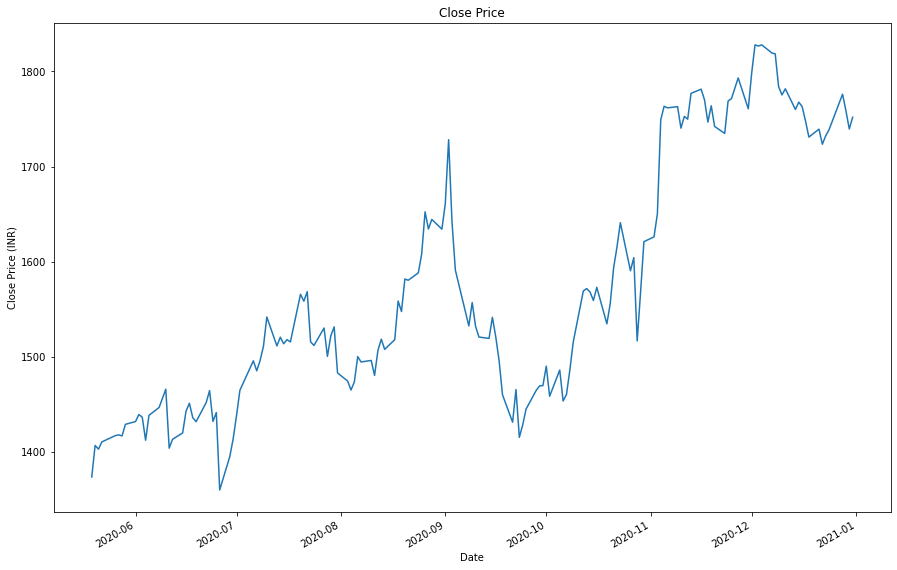

In [18]:
#Setting plot size and labels
plt.figure(figsize=(15,10))

df['Close'].plot()


plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price (INR)')

In [19]:
# calculating 7 day rolling mean
df.rolling(7).mean().head(20)

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2020-05-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-28,1406.430716,-0.999700,0.123286,0.798429,0.078286,1404.666696,1419.178571,1392.204991,1.581286e+06
2020-05-29,1414.350011,-0.999729,0.126143,0.793286,0.080571,1408.944266,1424.974278,1397.899990,1.658471e+06
2020-06-01,1417.935721,-0.999757,0.130857,0.786857,0.082286,1413.059989,1428.908552,1402.292847,1.595857e+06
2020-06-02,1423.138567,-0.999757,0.132143,0.784286,0.083571,1416.281424,1432.354265,1405.918562,1.580586e+06


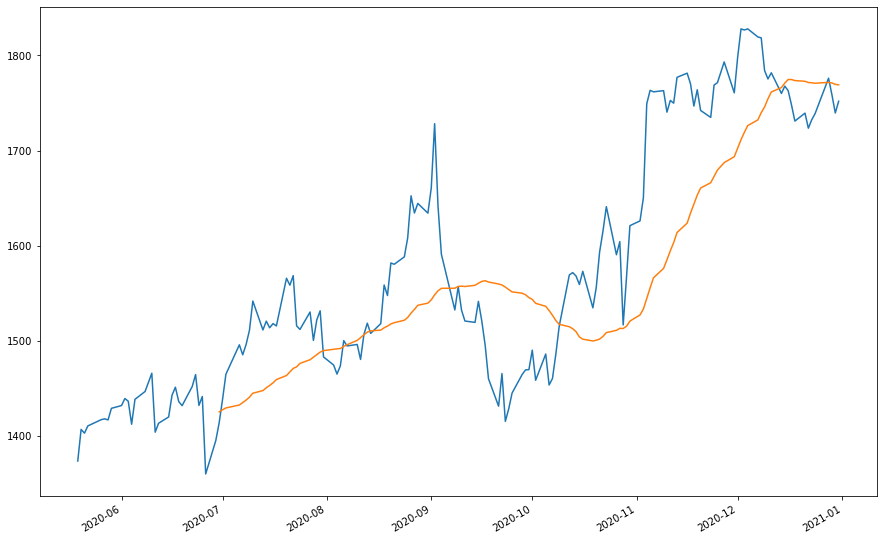

In [20]:
# setting figure size
plt.figure(figsize=(15,10))

# plotting the close price and a 30-day rolling mean of close price
df['Close'].plot()
df.rolling(window=30).mean()['Close'].plot()

In [21]:
# displaying stock data
df

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2020-05-19,1373.484985,-0.9996,0.115,0.813,0.072,1386.996948,1392.000000,1373.484985,1280600.0
2020-05-20,1406.719971,-0.9997,0.110,0.824,0.066,1389.579956,1410.420044,1387.250000,1655400.0
2020-05-21,1402.800049,-0.9998,0.127,0.792,0.081,1408.000000,1415.489990,1393.449951,1385000.0
2020-05-22,1410.420044,-0.9997,0.138,0.772,0.090,1396.709961,1412.760010,1391.829956,1309400.0
2020-05-26,1417.020020,-0.9998,0.131,0.791,0.078,1437.270020,1441.000000,1412.130005,2060600.0
...,...,...,...,...,...,...,...,...,...
2020-12-24,1738.849976,-0.9971,0.082,0.854,0.064,1735.000000,1746.000000,1729.109985,346800.0
2020-12-28,1776.089966,-0.9997,0.126,0.789,0.085,1751.635010,1790.728027,1746.334961,1393000.0
2020-12-29,1758.719971,-0.9998,0.136,0.774,0.090,1787.790039,1792.439941,1756.089966,1299400.0
2020-12-30,1739.520020,-0.9998,0.126,0.797,0.077,1762.010010,1765.094971,1725.599976,1306100.0


#### Data modelling

In [22]:
# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(df)-1))

# using 80% of data for training
train_end = int(data_to_use*0.8)
total_data = len(df)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 125
Number of records in Test Data: 33


In [23]:
# predicting one step ahead
steps_to_predict = 1


close_price = df.iloc[start:total_data,0] #close
compound = df.iloc[start:total_data,1] #compound
negative = df.iloc[start:total_data,2] #neg
neutral = df.iloc[start:total_data,3] #neu
positive = df.iloc[start:total_data,4] #pos
open_price = df.iloc[start:total_data,5] #open
high = df.iloc[start:total_data,6] #high
low = df.iloc[start:total_data,7] #low
volume = df.iloc[start:total_data,8] #volume

# printing close price
print("Close Price:")
close_price

Close Price:


2020-05-20    1406.719971
2020-05-21    1402.800049
2020-05-22    1410.420044
2020-05-26    1417.020020
2020-05-27    1417.839966
                 ...     
2020-12-24    1738.849976
2020-12-28    1776.089966
2020-12-29    1758.719971
2020-12-30    1739.520020
2020-12-31    1751.880005
Name: Close, Length: 157, dtype: float64

In [24]:
# shifting next day close
close_price_shifted = close_price.shift(-1) 

# shifting next day compound
compound_shifted = compound.shift(-1) 

# concatenating the captured training data into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# setting column names of the revised stock data
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

# dropping nulls
data = data.dropna()    
data.head(10)

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
2020-05-20,1406.719971,1402.800049,-0.9997,-0.9998,1655400.0,1389.579956,1410.420044,1387.250000
2020-05-21,1402.800049,1410.420044,-0.9998,-0.9997,1385000.0,1408.000000,1415.489990,1393.449951
2020-05-22,1410.420044,1417.020020,-0.9997,-0.9998,1309400.0,1396.709961,1412.760010,1391.829956
2020-05-26,1417.020020,1417.839966,-0.9998,-0.9996,2060600.0,1437.270020,1441.000000,1412.130005
2020-05-27,1417.839966,1416.729980,-0.9996,-0.9997,1685800.0,1417.250000,1421.739990,1391.290039
2020-05-28,1416.729980,1428.920044,-0.9997,-0.9998,1692200.0,1396.859985,1440.839966,1396.000000
2020-05-29,1428.920044,1431.819946,-0.9998,-0.9999,1820900.0,1416.939941,1432.569946,1413.349976
2020-06-01,1431.819946,1439.219971,-0.9999,-0.9998,1217100.0,1418.390015,1437.959961,1418.000000
2020-06-02,1439.219971,1436.380005,-0.9998,-0.9996,1278100.0,1430.550049,1439.609985,1418.829956
2020-06-03,1436.380005,1412.180054,-0.9996,-0.9994,1256200.0,1438.300049,1446.552002,1429.776978


In [25]:
# setting the target variable as the shifted close_price
y = data['close_price_shifted']
y

2020-05-20    1402.800049
2020-05-21    1410.420044
2020-05-22    1417.020020
2020-05-26    1417.839966
2020-05-27    1416.729980
                 ...     
2020-12-23    1738.849976
2020-12-24    1776.089966
2020-12-28    1758.719971
2020-12-29    1739.520020
2020-12-30    1751.880005
Name: close_price_shifted, Length: 156, dtype: float64

In [26]:
# setting the features dataset for prediction  
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
2020-05-20,1406.719971,-0.9997,-0.9998,1655400.0,1389.579956,1410.420044,1387.250000
2020-05-21,1402.800049,-0.9998,-0.9997,1385000.0,1408.000000,1415.489990,1393.449951
2020-05-22,1410.420044,-0.9997,-0.9998,1309400.0,1396.709961,1412.760010,1391.829956
2020-05-26,1417.020020,-0.9998,-0.9996,2060600.0,1437.270020,1441.000000,1412.130005
2020-05-27,1417.839966,-0.9996,-0.9997,1685800.0,1417.250000,1421.739990,1391.290039
...,...,...,...,...,...,...,...
2020-12-23,1732.380005,-0.9996,-0.9971,1033800.0,1728.109985,1747.989990,1725.040039
2020-12-24,1738.849976,-0.9971,-0.9997,346800.0,1735.000000,1746.000000,1729.109985
2020-12-28,1776.089966,-0.9997,-0.9998,1393000.0,1751.635010,1790.728027,1746.334961
2020-12-29,1758.719971,-0.9998,-0.9998,1299400.0,1787.790039,1792.439941,1756.089966


#### Scaling the features and dependent variable

In [27]:
# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y

(array([[-0.79995321, -0.99979973, -0.99989986, ..., -0.86533472,
         -0.93436639, -0.83079645],
        [-0.8167018 , -0.99989986, -0.99979973, ..., -0.78633637,
         -0.91191313, -0.80472652],
        [-0.78414397, -0.99979973, -0.99989986, ..., -0.83475614,
         -0.92400339, -0.81153837],
        ...,
        [ 0.77824765, -0.99979973, -0.99989986, ...,  0.68741684,
          0.74990289,  0.67910579],
        [ 0.70403117, -0.99989986, -0.99989986, ...,  0.84247552,
          0.75748444,  0.72012423],
        [ 0.62199587, -0.99989986, -0.99969959, ...,  0.73191228,
          0.63638182,  0.59191807]]),
 array([[-0.8167018 ],
        [-0.78414397],
        [-0.75594437],
        [-0.752441  ],
        [-0.75718362],
        [-0.70509934],
        [-0.69270898],
        [-0.66109102],
        [-0.67322529],
        [-0.77662401],
        [-0.66463716],
        [-0.62951583],
        [-0.5887115 ],
        [-0.54730945],
        [-0.81225856],
        [-0.77235133],
     

#### Dividing the data into training and test set

In [28]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in the Training set X: (125, 7) and y: (125, 1)
Number of rows and columns in the Test set X: (30, 7) and y: (30, 1)


In [29]:
# reshaping the feature dataset for feeding into the model
X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (125, 7, 1)
Shape of Test set X: (30, 7, 1)


#### Modelling

In [30]:
# setting the seed to achieve consistent and less random predictions at each execution
np.random.seed(2016)

# setting the model architecture
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))
model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

# printing the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 100)            40800     
_________________________________________________________________
dropout (Dropout)            (None, 7, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 100)            80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [31]:
# compiling the model
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=8, verbose=1)


Epoch 1/10
13/13 [==============================] - 25s 166ms/step - loss: 0.1398 - val_loss: 0.3950
Epoch 2/10
13/13 [==============================] - 0s 12ms/step - loss: 0.0494 - val_loss: 0.3607
Epoch 3/10
13/13 [==============================] - 0s 12ms/step - loss: 0.0589 - val_loss: 0.2580
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 0.0410 - val_loss: 0.2010
Epoch 5/10
13/13 [==============================] - 0s 12ms/step - loss: 0.0328 - val_loss: 0.1015
Epoch 6/10
13/13 [==============================] - 0s 13ms/step - loss: 0.0264 - val_loss: 0.0592
Epoch 7/10
13/13 [==============================] - 0s 12ms/step - loss: 0.0333 - val_loss: 0.0876
Epoch 8/10
13/13 [==============================] - 0s 12ms/step - loss: 0.0269 - val_loss: 0.0774
Epoch 9/10
13/13 [==============================] - 0s 12ms/step - loss: 0.0222 - val_loss: 0.0643
Epoch 10/10
13/13 [==============================] - 0s 12ms/step - loss: 0.0190 - val_loss: 0.0443


In [32]:
# saving the model as a json file
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights('model.h5')
print('Model is saved to the disk')

Model is saved to the disk


#### Performing Predictions

In [33]:
predictions = model.predict(X_test) 

# unscaling the predictions
predictions = scaler_y.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))

# printing the predictions
print('Predictions:')
predictions[0:5]

Predictions:


array([[1700.4526],
       [1688.3514],
       [1694.1991],
       [1710.3463],
       [1700.8801]], dtype=float32)

#### Evaluating the Model

In [34]:
# calculating the training mean-squared-error
train_loss = model.evaluate(X_train, y_train, batch_size = 1)

# calculating the test mean-squared-error
test_loss = model.evaluate(X_test, y_test, batch_size = 1)

# printing the training and the test mean-squared-errors
print('Train Loss =', round(train_loss,4))
print('Test Loss =', round(test_loss,4))

30/30 [==============================] - 0s 2ms/step - loss: 0.0848
Train Loss = 0.0253
Test Loss = 0.0848


In [35]:
# calculating root mean squared error
root_mean_square_error = np.sqrt(np.mean(np.power((y_test - predictions),2)))
print('Root Mean Square Error =', round(root_mean_square_error,4))

Root Mean Square Error = 1704.7657


In [36]:
# unscaling the test feature dataset, x_test
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))

# unscaling the test y dataset, y_test
y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

#### Plotting the Predicted data against Test data

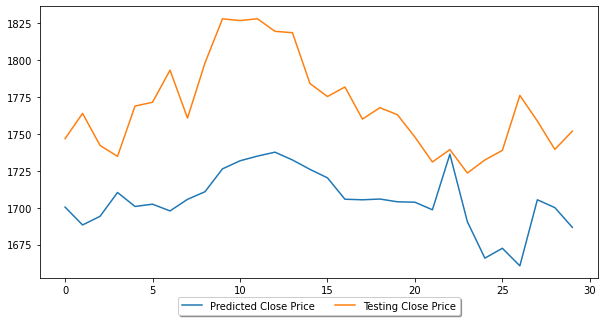

In [38]:
# plotting
plt.figure(figsize=(10,5))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(predictions, label="Predicted Close Price")
plt.plot([row[0] for row in y_test], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()